# House Pricing regression problem

In [110]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("colorblind")
sns.set_style("darkgrid") # 使用darkgrid可视化效果要好一点
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer

## 1. 分析数据

In [111]:
train = pd.read_csv('./data/train.csv', index_col=0)
test = pd.read_csv('./data//test.csv', index_col=0)


print("train: ", train.shape)
print("test: ", test.shape)
train.head()

train:  (1460, 80)
test:  (1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


首先将训练集和测试集的数据合并，以对数据集整体进行分析。

In [112]:
X = pd.concat([train.drop("SalePrice", axis=1),test], axis=0)  # 测试集中没有SalePrice，故删除训练集中该特征用以做特征对齐
y = train[['SalePrice']]

了解每种特征的数据类型，以便对它们进行区别分析。

In [113]:
X.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

将数据分为数值型和类别型，并分别对数字型和类别型特征进行描述性统计分析。

In [114]:
numeric_ = X.select_dtypes(exclude=['object']).drop(['MSSubClass'], axis=1).copy()  # 注意这里MSSubClass特征虽然数据类型为int64，但是根据数据描述文本可知其本身是类别型特征，故去除
numeric_.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [115]:
cat_train = X.select_dtypes(include=['object']).copy()
cat_train['MSSubClass'] = X['MSSubClass']  # 类别型特征需要把MSSubClass加上
cat_train.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'MSSubClass'],
      dtype='object')

### 1.1. 单变量分析

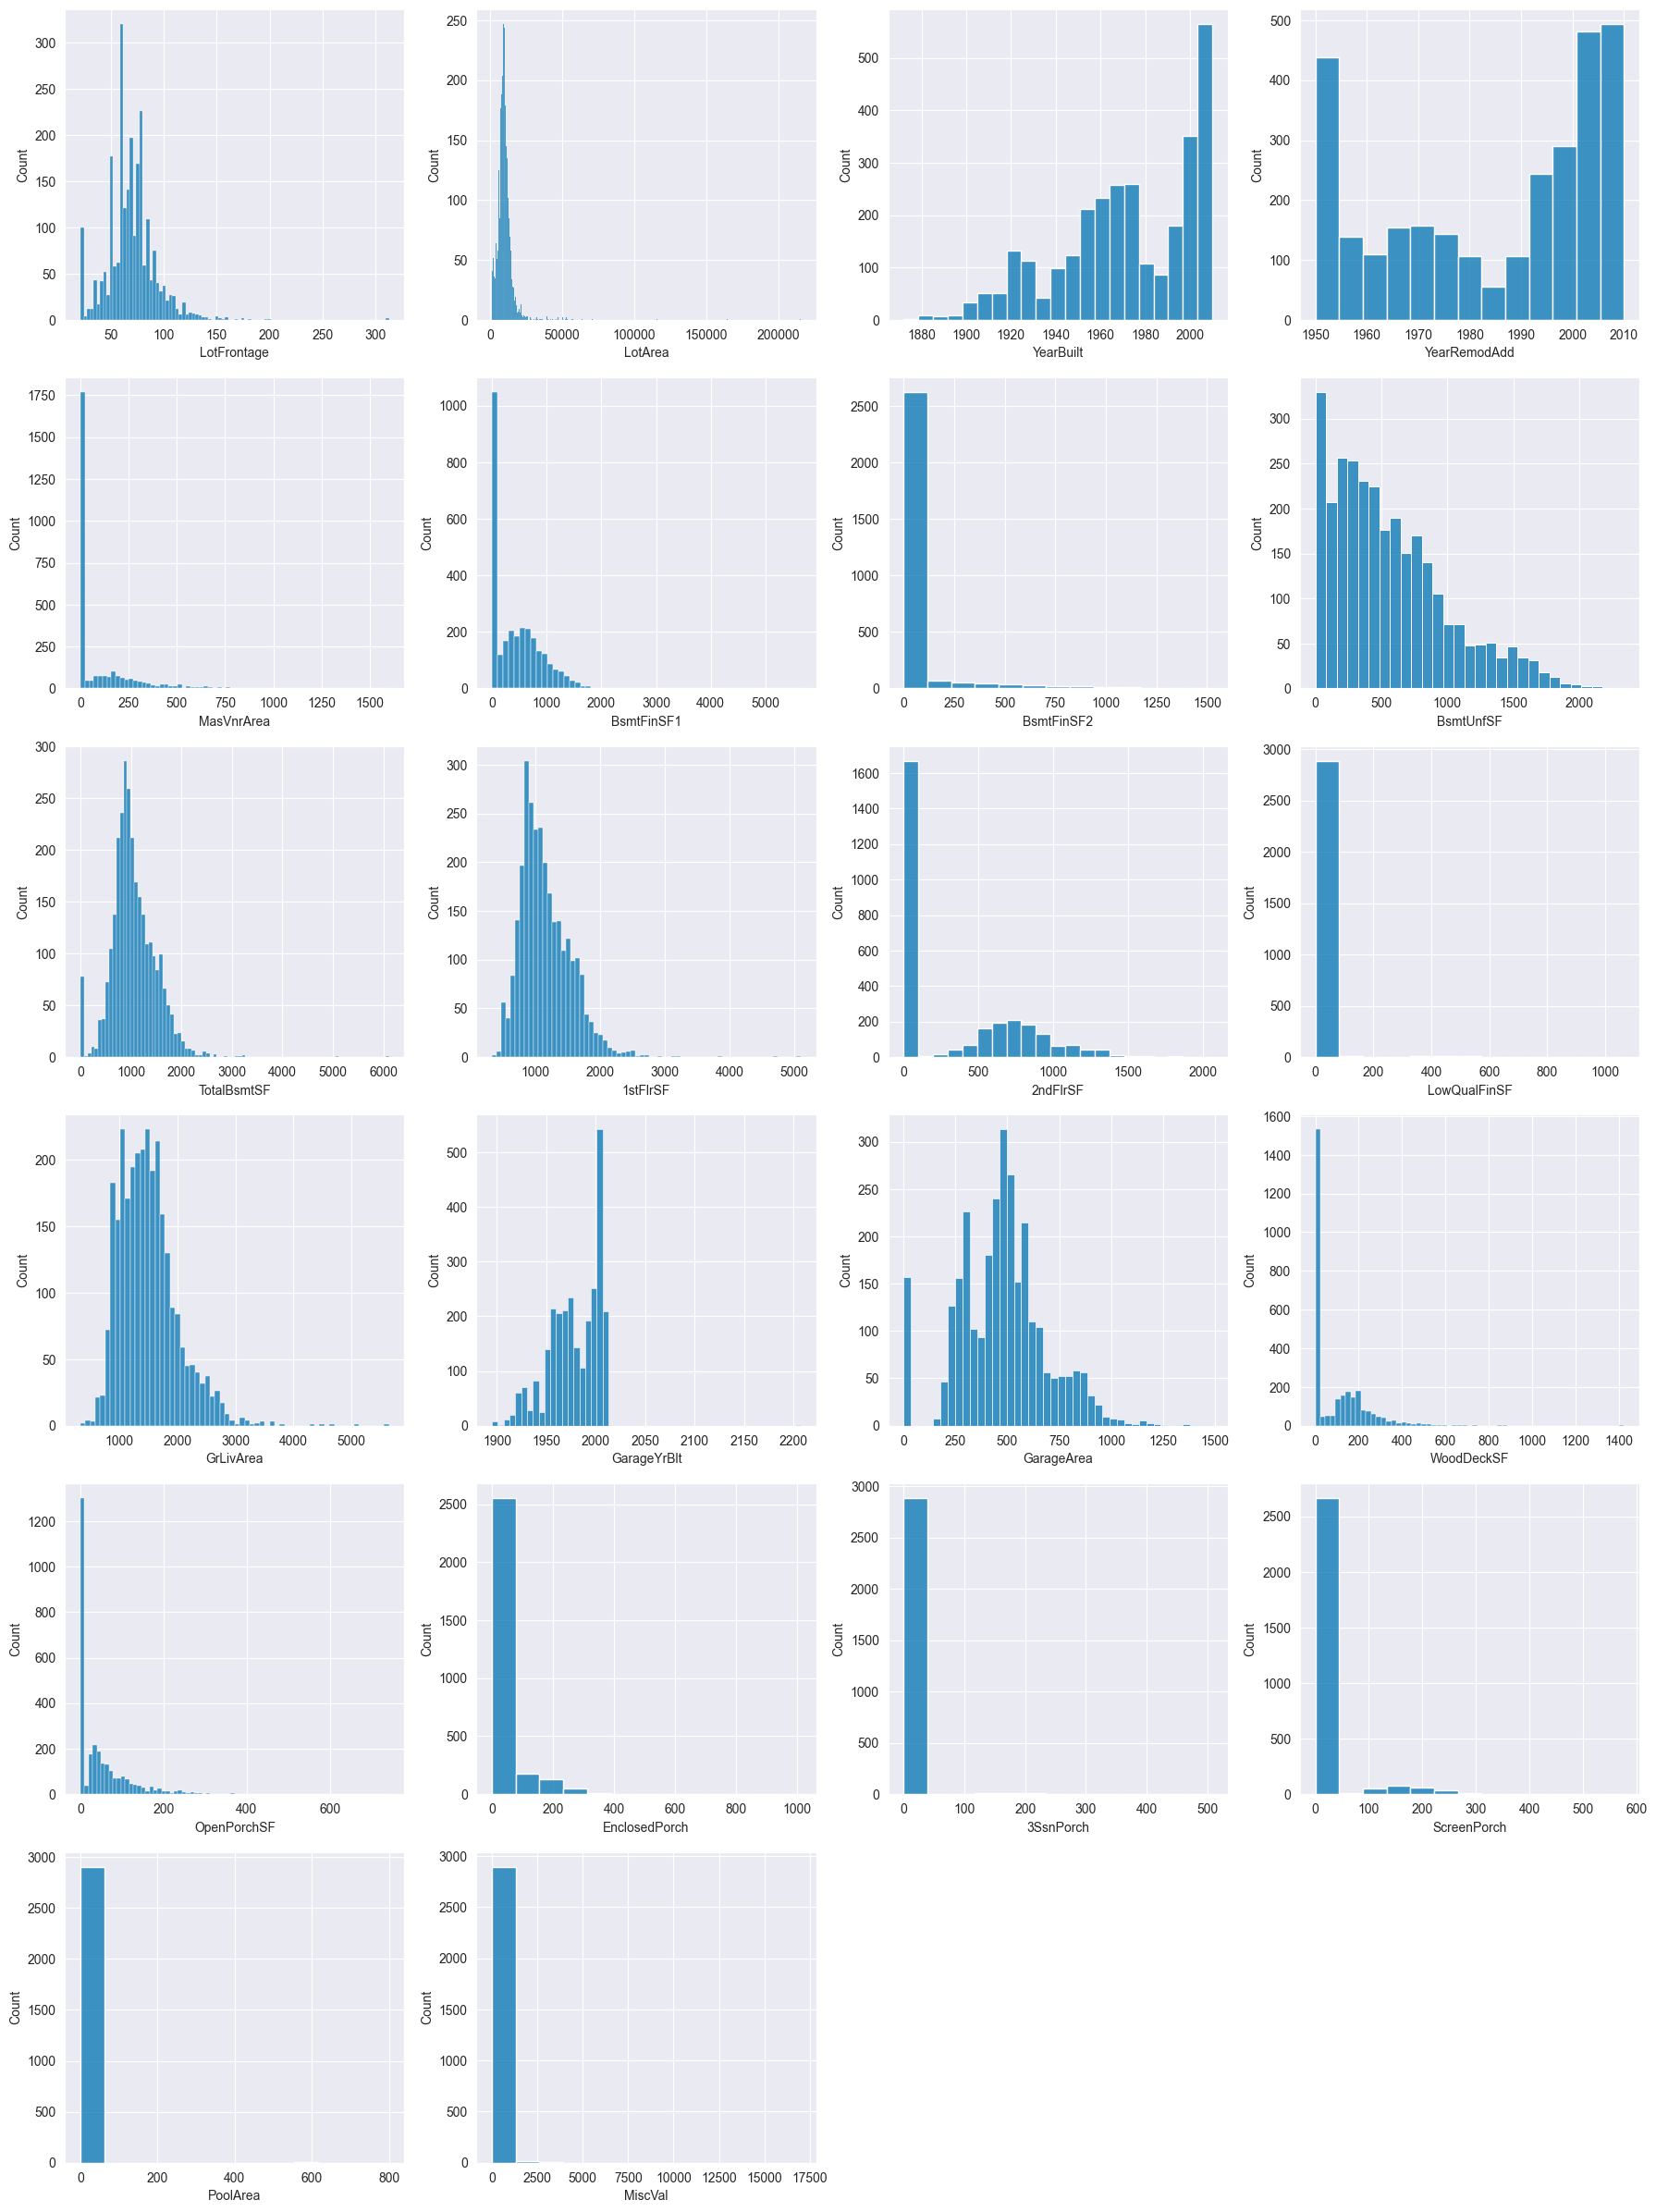

In [116]:
cont_num_var = [
    'LotFrontage', 'LotArea', 'YearBuilt',
    'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
    'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
    'GarageYrBlt', 'GarageArea', 'WoodDeckSF',
    'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
    'PoolArea', 'MiscVal'
]   # 这是连续的数值特征
print()
fig = plt.figure(figsize=(18,24))
for index,col in enumerate(cont_num_var):
    plt.subplot(6,4,index+1)
    sns.histplot(numeric_.loc[:,col].dropna(), kde=False)
fig.tight_layout(pad=1.0)

从上面的图表中可以看出，一些变量大部分时间都是单一取值：
1. BsmtFinSF2
2. LowQualFinSF
3. EnclosedPorch
4. 3SsnPorch
5. ScreenPorch
6. PoolArea
7. MiscVal


所有这些特征都呈现高度偏斜，主要由大量的零值组成。在预测房价方面，分布中存在大量的零值并没有为模型提供太多信息。因此，在我们的预处理步骤中，我们将移除这些零值。

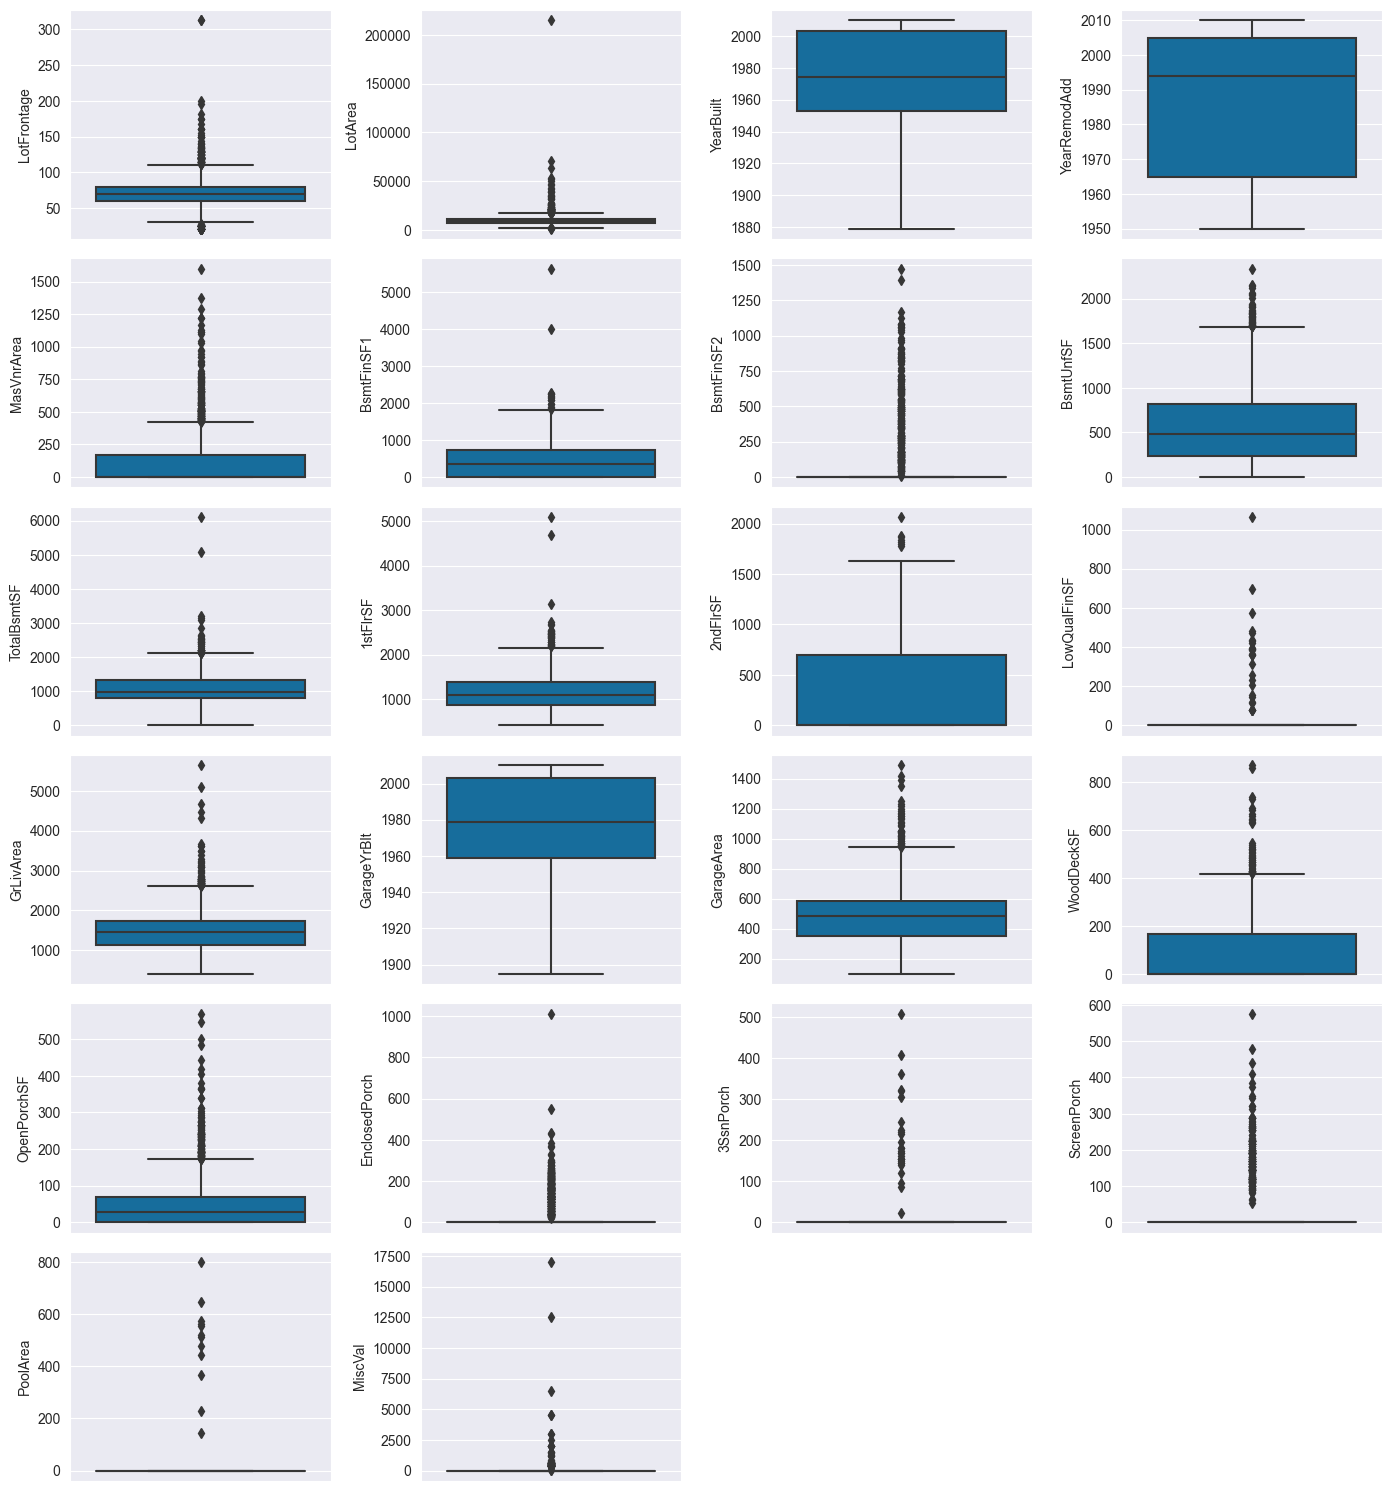

In [117]:
fig = plt.figure(figsize=(14,15))
for index,col in enumerate(cont_num_var):
    plt.subplot(6,4,index+1)
    sns.boxplot(y=col, data=numeric_.dropna())
fig.tight_layout(pad=1.0)

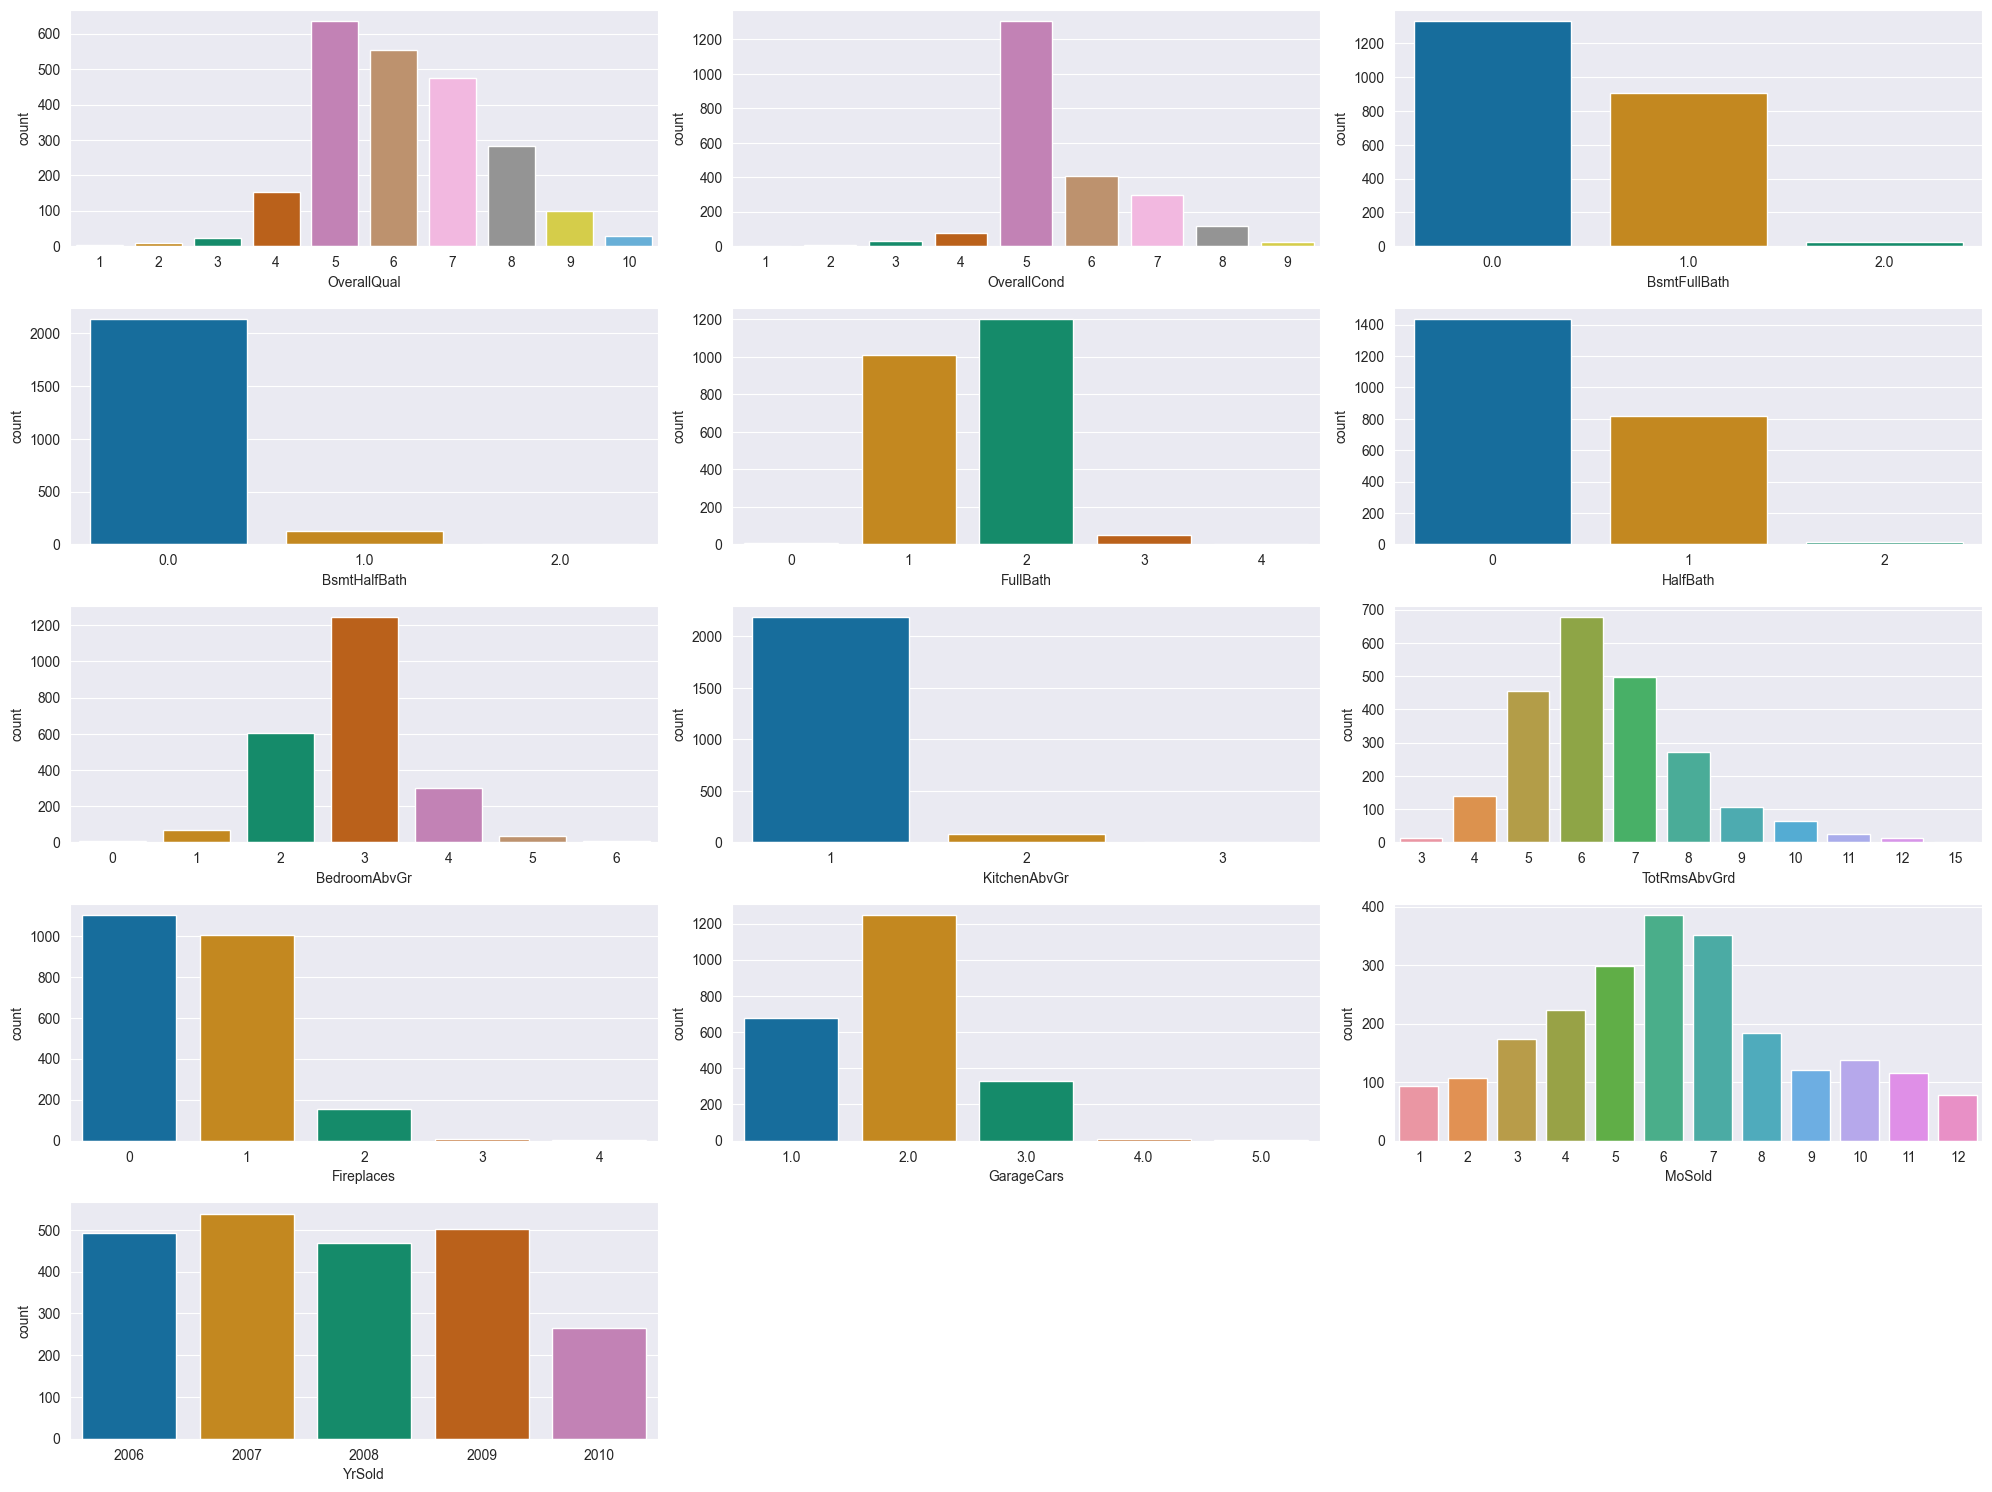

In [118]:
disc_num_var = [x for x in list(numeric_.columns) if x not in cont_num_var]  # 这是离散的数值特征

fig = plt.figure(figsize=(20,15))
for index,col in enumerate(disc_num_var):
    plt.subplot(5,3,index+1)
    sns.countplot(x=col, data=numeric_.dropna())
fig.tight_layout(pad=1.0)

**类别特征**

在分类特征的情况下，我们通常会使用计数图 (countplots) 来可视化每个特征中每个不同值的计数。我们可以看到，一些分类特征，如Utilities和Condition2，主要由一个值组成，这并没有添加任何有用的信息。因此，我们在后续处理步骤中也会将它们移除。

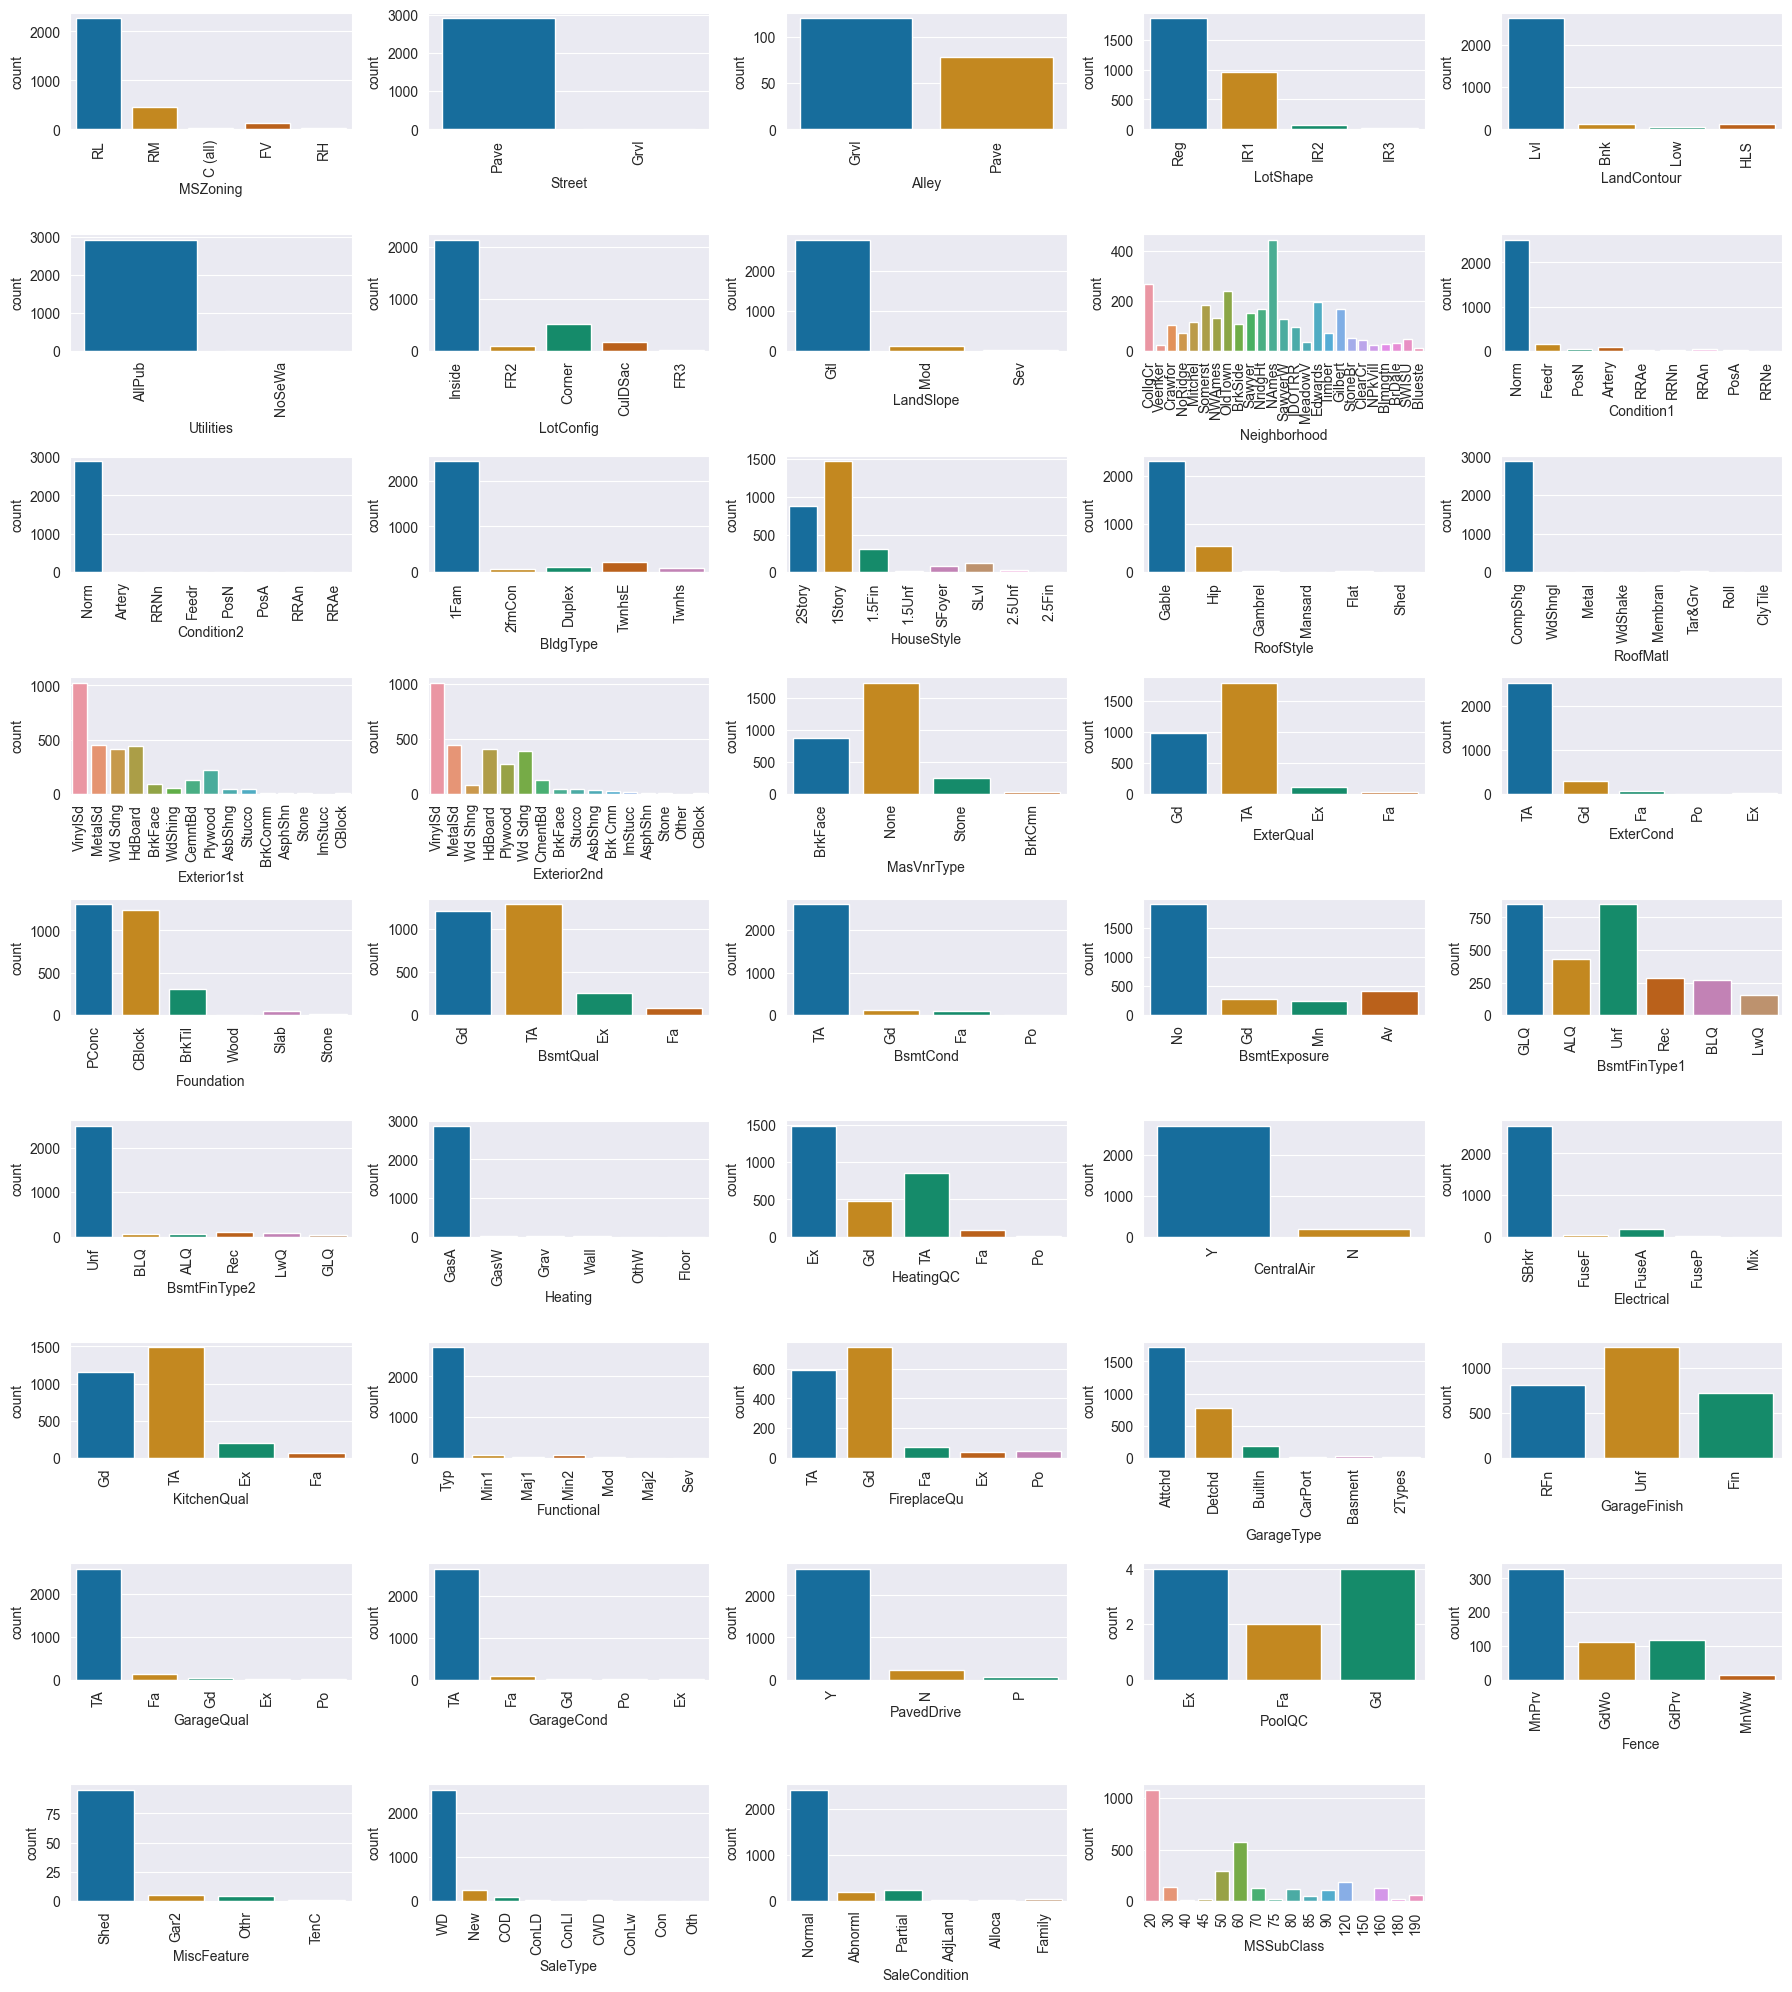

In [119]:
fig = plt.figure(figsize=(18,20))
for index in range(len(cat_train.columns)):
    plt.subplot(9,5,index+1)
    sns.countplot(x=cat_train.iloc[:,index], data=cat_train.dropna())
    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

### 1.2. 相关性分析

双变量分析通过观察两个不同的特征，旨在识别它们之间可能存在的关系或独特模式。其中一个常用的技术是通过相关矩阵。相关矩阵是揭示两个连续特征之间线性关系（相关性）的有效工具。相关性不仅允许我们确定哪些特征对Saleprice很重要，还作为调查我们独立预测变量之间是否存在多重共线性的手段。

多重共线性发生在两个或更多独立变量之间高度相关的情况下。在这种情况下，它导致回归系数的精度损失，影响我们识别对模型最有用的最重要特征的能力。

<AxesSubplot:>

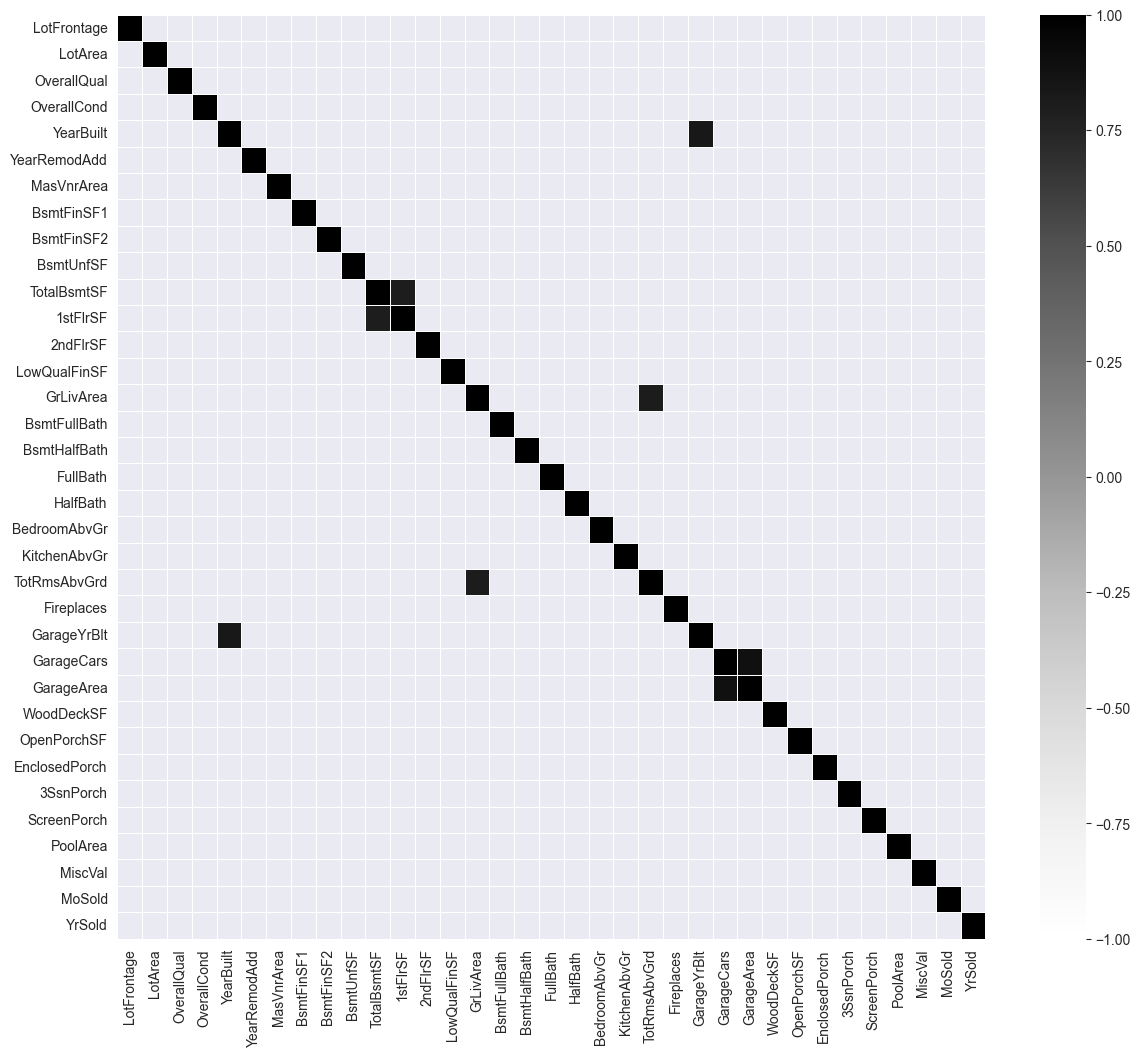

In [120]:
plt.figure(figsize=(14,12))
correlation = numeric_.corr()
sns.heatmap(correlation, mask=correlation < 0.7, linewidth=0.5, cmap='Greys', vmin=-1, vmax=1)

高度相关的变量：

- GarageYrBlt 和 YearBuilt
- TotRmsAbvGrd 和 GrLivArea
- 1stFlrSF 和 TotalBsmtSF
- GarageArea 和 GarageCars

从相关矩阵中，我们已经确定了上述变量彼此之间存在高度相关性。这一发现将在后续的预处理步骤中指导我们，因为我们旨在移除高度相关的特征，以避免在模型中出现性能损失。

**识别数值预测变量与目标变量（SalePrice）之间的关系**

在下面，我们按与SalePrice之间的线性关系强度对其他特征进行了排序。OverallQual和GrLivArea与SalePrice之间的线性关系最为显著。因此，这两个特征将是预测房价的重要因素。

In [121]:
numeric_train = train.select_dtypes(exclude=['object'])
correlation = numeric_train.corr()
correlation[['SalePrice']].sort_values(['SalePrice'], ascending=False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


使用散点图也可以帮助我们识别数值特征之间的潜在线性关系。尽管散点图不能提供有关特征之间线性关系强度的定量证据，但它有助于可视化相关矩阵无法计算的任何关系，例如二次、指数关系等。下面是各个数值特征跟SalePrice之间的散点图。

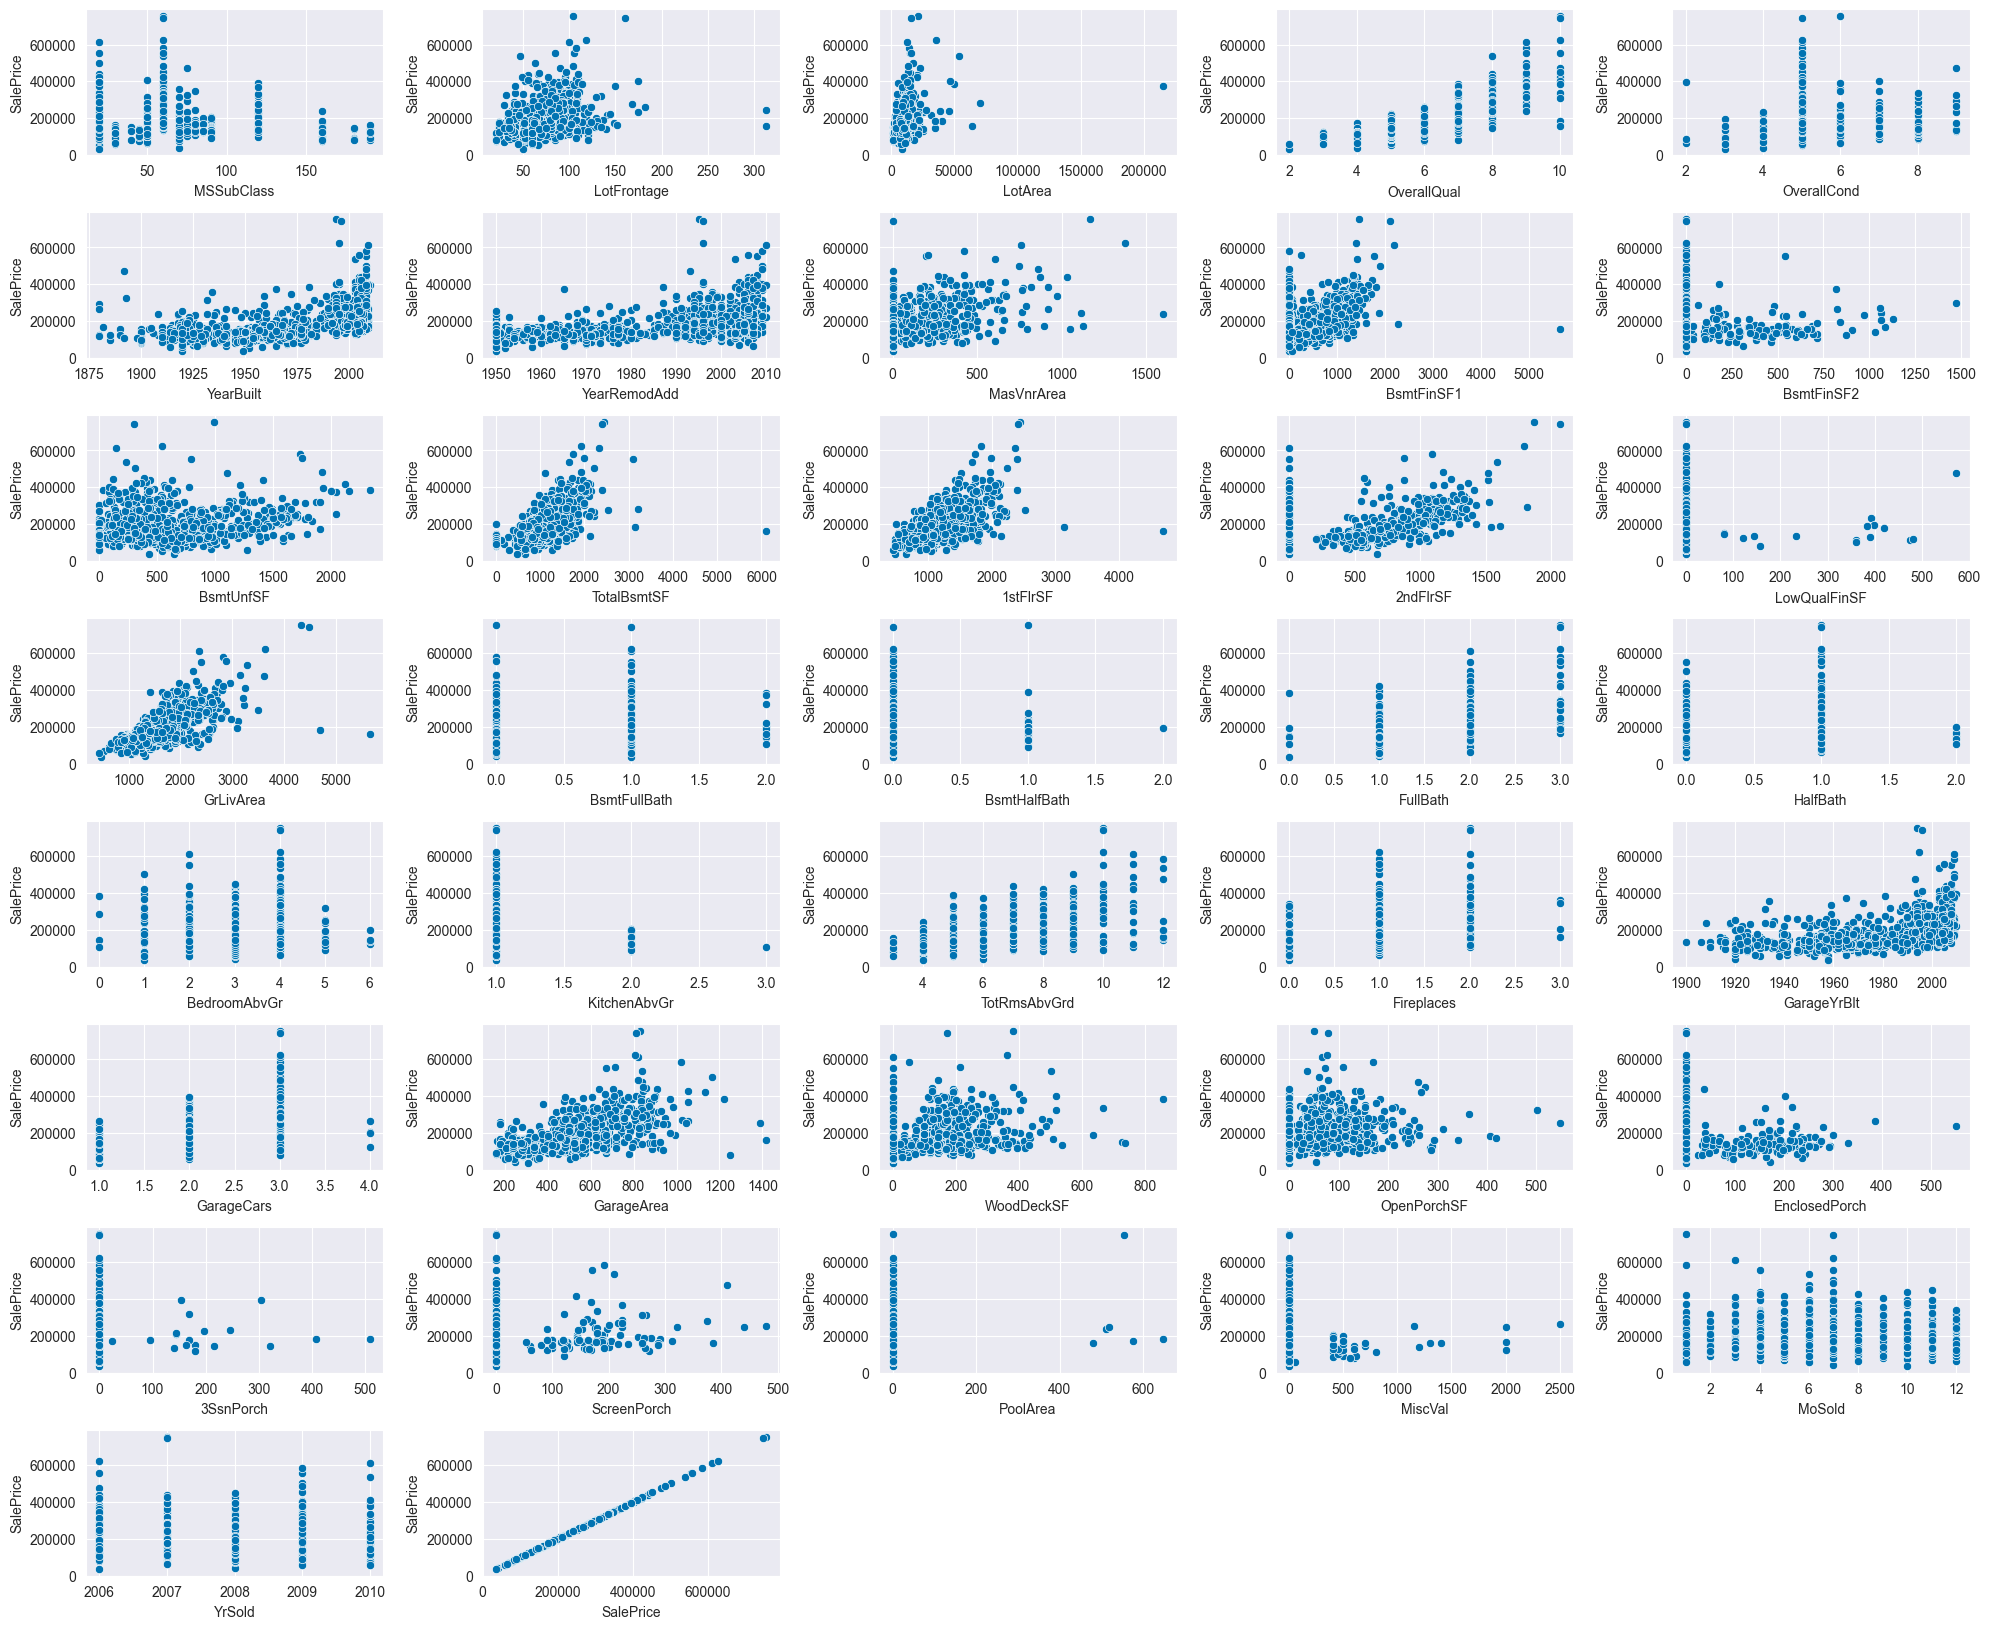

In [122]:
fig = plt.figure(figsize=(20,20))
for index in range(len(numeric_train.columns)):
    plt.subplot(10,5,index+1)
    sns.scatterplot(x=numeric_train.iloc[:,index], y='SalePrice', data=numeric_train.dropna())
fig.tight_layout(pad=1.0)

## 2. 数据预处理
现在我们基本完成了对数据的分析，通过各种分析和可视化获得了一些先验知识，我们将利用这些见解来指导预处理决策，以便为模型提供干净且无误的数据，以便后续进行训练。

### 2.1. 去除多余的特征

**（1）首先去除一些线性相关度较高的特征，以避免多重共线性问题。**

从上述相关矩阵中，我们确定了一些高度相关的特征：

- GarageYrBlt 和 YearBuilt
- TotRmsAbvGrd 和 GrLivArea
- 1stFlrSF 和 TotalBsmtSF
- GarageArea 和 GarageCars

这些特征之间存在较强的共线性，可能会影响模型的性能。在预处理阶段，我们可能需要考虑移除其中一些特征，以减少多重共线性的影响。

In [123]:
X.drop(['GarageYrBlt','TotRmsAbvGrd','1stFlrSF','GarageCars'], axis=1, inplace=True)

**（2）然后统计有大量缺失值的特征并去除**

特征的缺失值统计如下表，可知需要删除以下特征：
*  PoolQC
*  MiscFeature
*  Alley

<AxesSubplot:title={'center':'Number of missing rows'}, xlabel='features', ylabel='sum'>

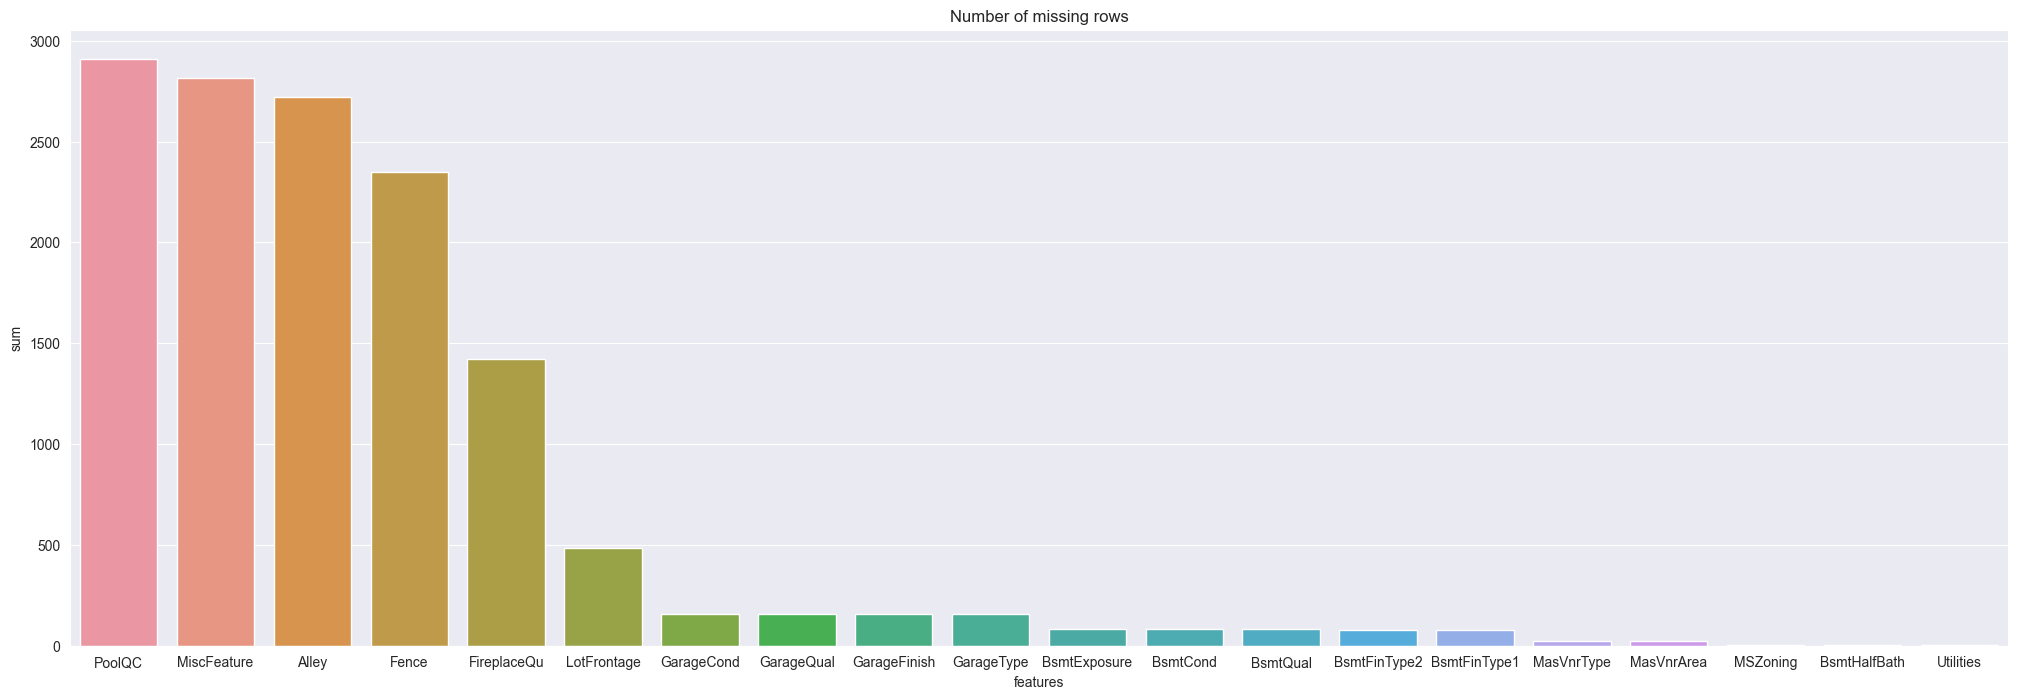

In [124]:
plt.figure(figsize=(25,8))
plt.title('Number of missing rows')
missing_count = pd.DataFrame(X.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).head(20).reset_index()
missing_count.columns = ['features','sum']
sns.barplot(x='features',y='sum', data = missing_count)

In [125]:
X.drop(['PoolQC','MiscFeature','Alley'], axis=1, inplace=True)

**（3）之后删除一些与SalePrice相关度不高的特征**

删除特征包括：
* MoSold
* YrSold

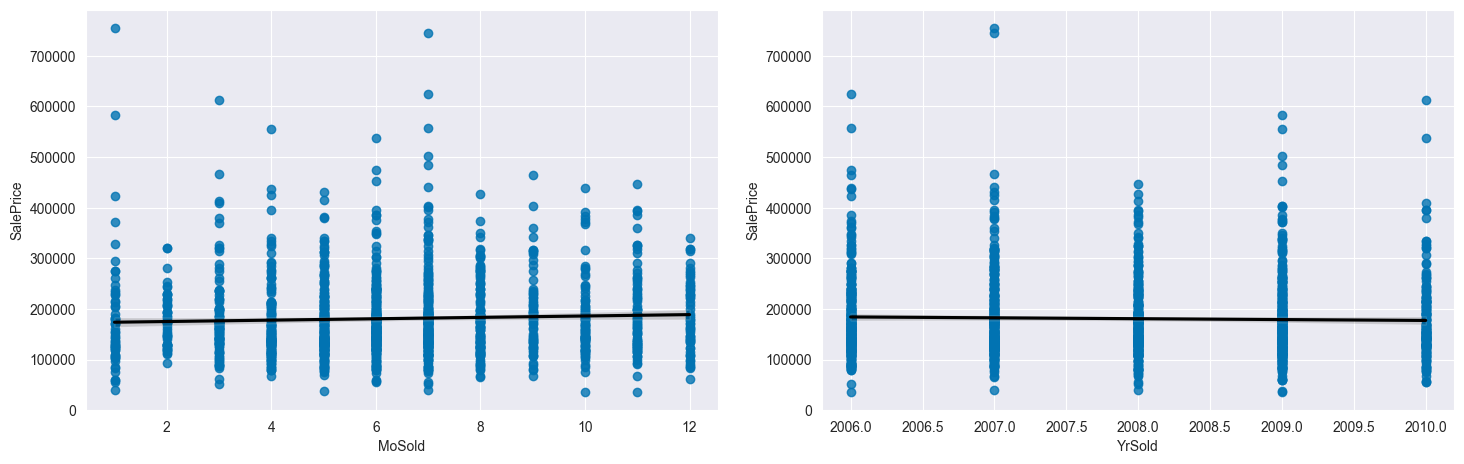

In [126]:
fig,axes = plt.subplots(1,2, figsize=(15,5))
sns.regplot(x=numeric_train['MoSold'], y='SalePrice', data=numeric_train, ax = axes[0], line_kws={'color':'black'})
sns.regplot(x=numeric_train['YrSold'], y='SalePrice', data=numeric_train, ax = axes[1],line_kws={'color':'black'})
fig.tight_layout(pad=2.0)

In [127]:
X.drop(['MoSold','YrSold'], axis=1, inplace=True)

**（4）最后移除主要只有一个值的特征**

这里设置阈值为0.96，即如果一个特征96%的值都是相同的，那么就删除这个特征。

In [128]:
cat_col = X.select_dtypes(include=['object']).columns
overfit_cat = []
for i in cat_col:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 96:
        overfit_cat.append(i)

overfit_cat = list(overfit_cat)
X = X.drop(overfit_cat, axis=1)

In [129]:
num_col = X.select_dtypes(exclude=['object']).drop(['MSSubClass'], axis=1).columns
overfit_num = []
for i in num_col:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 96:
        overfit_num.append(i)

overfit_num = list(overfit_num)
X = X.drop(overfit_num, axis=1)

In [130]:
print("Categorical Features with >96% of the same value: ",overfit_cat)
print("Numerical Features with >96% of the same value: ",overfit_num)

Categorical Features with >96% of the same value:  ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']
Numerical Features with >96% of the same value:  ['LowQualFinSF', '3SsnPorch', 'PoolArea', 'MiscVal']


### 2.2. 异常值处理

异常值可能是那些与大多数数据差异很大的值，它们有时可能会对模型的性能产生负面影响。

在数据分析阶段，我们通过使用箱线图（boxplot）分析了各特征值的数据分布，确定了以下特征存在极端异常值：

- LotFrontage
- LotArea
- BsmtFinSF1
- TotalBsmtSF
- GrLivArea

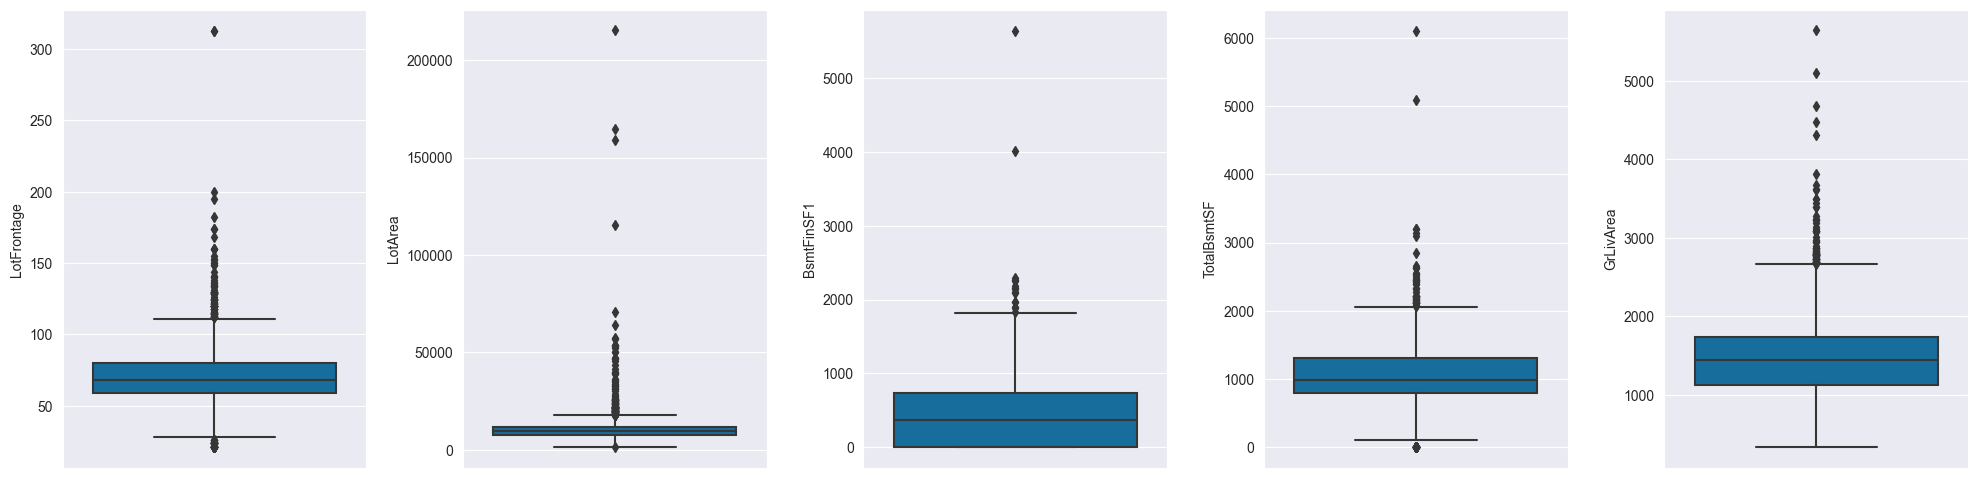

In [131]:
out_col = ['LotFrontage','LotArea','BsmtFinSF1','TotalBsmtSF','GrLivArea']
fig = plt.figure(figsize=(20,5))
for index,col in enumerate(out_col):
    plt.subplot(1,5,index+1)
    sns.boxplot(y=col, data=X)
fig.tight_layout(pad=1.5)

In [132]:
train = train.drop(train[train['LotFrontage'] > 200].index)
train = train.drop(train[train['LotArea'] > 100000].index)
train = train.drop(train[train['BsmtFinSF1'] > 4000].index)
train = train.drop(train[train['TotalBsmtSF'] > 5000].index)
train = train.drop(train[train['GrLivArea'] > 4000].index)

In [133]:
X.shape

(2919, 61)

### 2.3. 缺失值处理

我们的机器学习模型无法处理缺失值，因此我们需要根据对特征的了解来处理它们。这些缺失值在我们之前的数据探索中被标记为NAN。

In [134]:
pd.DataFrame(X.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).head(15)

,sum
Fence,2348
FireplaceQu,1420
LotFrontage,486
GarageFinish,159
GarageCond,159
GarageQual,159
GarageType,157
BsmtCond,82
BsmtExposure,82
BsmtQual,81


**类别特征**

我们这里直接用出现频率最高的值填补

In [135]:
cat = ['GarageType','GarageFinish','BsmtFinType2','BsmtExposure','BsmtFinType1', 
       'GarageCond','GarageQual','BsmtCond','BsmtQual','FireplaceQu','Fence',"KitchenQual",
       "HeatingQC",'ExterQual','ExterCond']

X[cat] = X[cat].fillna("NA")

In [136]:
#categorical
cols = ["MasVnrType", "MSZoning", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "Functional"]
X[cols] = X.groupby("Neighborhood")[cols].transform(lambda x: x.fillna(x.mode()[0]))

**数值特征**


对于数值特征，常见的处理方法是用特征分布的均值替换缺失值。然而，某些特征如LotFrontage和GarageArea在它们的分布中具有较大的方差。通过按Neighborhood分组，我们会发现用这些列的均值取代缺失值的均值会有很大差异，因为每个邻里的LotFrontage和GarageArea的均值不同。因此，我决定按Neighborhood分组，用相应的均值来填充缺失值。

In [137]:
# 这是两个变量的整体平均值
print("Mean of LotFrontage: ", X['LotFrontage'].mean())
print("Mean of GarageArea: ", X['GarageArea'].mean())

Mean of LotFrontage:  69.30579531442663
Mean of GarageArea:  472.8745716244003


<AxesSubplot:xlabel='Neighborhood', ylabel='GarageArea_mean'>

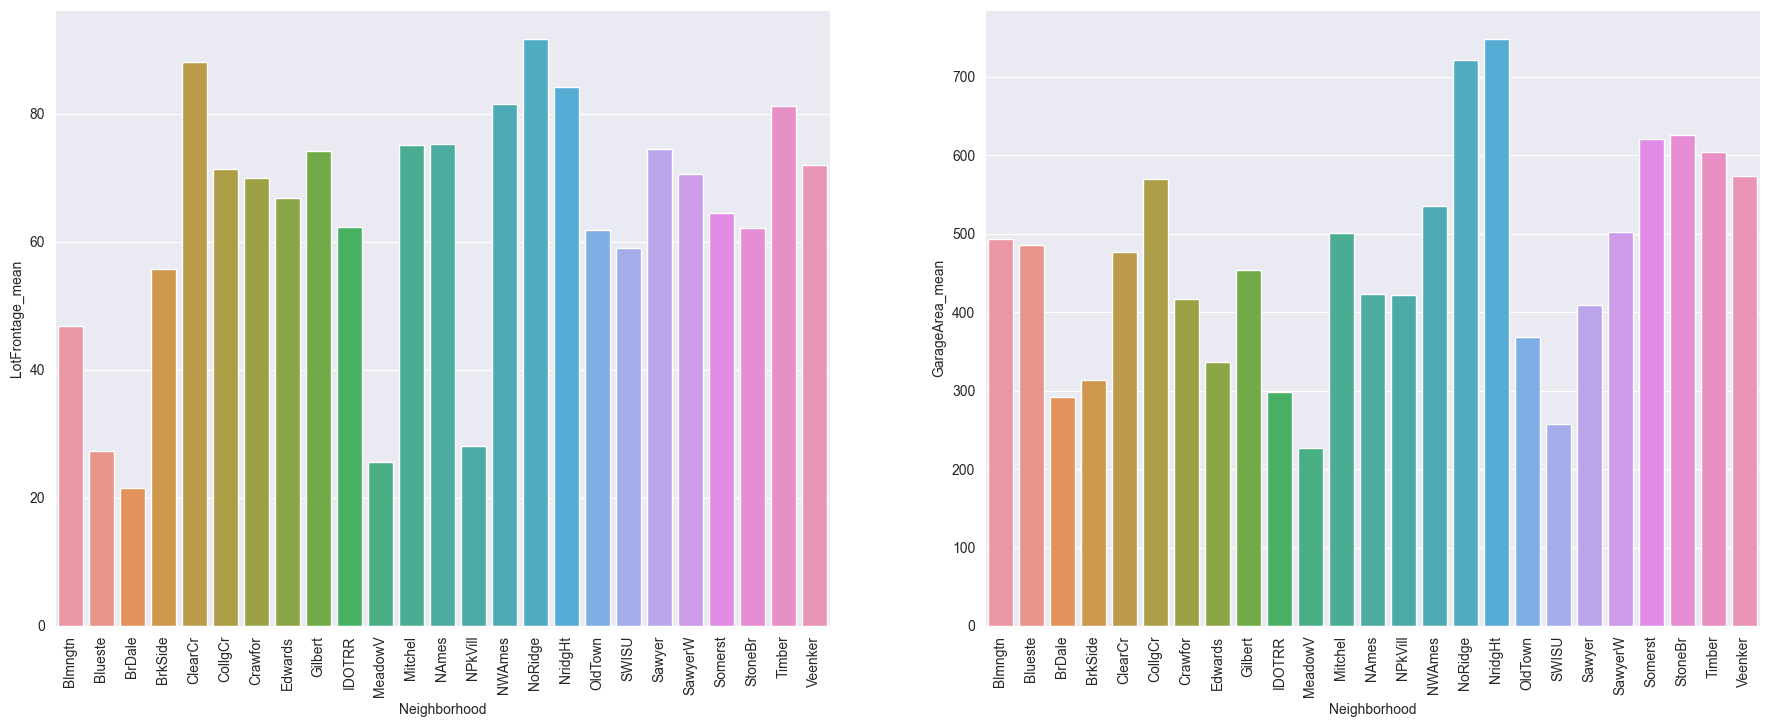

In [138]:
# 这是根据Neighborhood分组后每组的均值
neigh_lot = X.groupby('Neighborhood')['LotFrontage'].mean().reset_index(name='LotFrontage_mean')
neigh_garage = X.groupby('Neighborhood')['GarageArea'].mean().reset_index(name='GarageArea_mean')

fig, axes = plt.subplots(1,2,figsize=(22,8))
axes[0].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='LotFrontage_mean', data=neigh_lot, ax=axes[0])
axes[1].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='GarageArea_mean', data=neigh_garage, ax=axes[1])

In [139]:
#for correlated relationship
X['LotFrontage'] = X.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
X['GarageArea'] = X.groupby('Neighborhood')['GarageArea'].transform(lambda x: x.fillna(x.mean()))
X['MSZoning'] = X.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

#numerical
cont = ["BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea"]
X[cont] = X[cont] = X[cont].fillna(X[cont].mean())

In [140]:
X['MSSubClass'] = X['MSSubClass'].apply(str)

**映射序数特征**

有些列本质上是有序的，表示某些房屋特征的质量或条件。在这种情况下，我们将相应的字符串映射到一个值。质量越好，值越高。

In [141]:
ordinal_map = {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}
fintype_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
expose_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}
fence_map = {'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1,'NA': 0}

In [142]:
ord_col = ['ExterQual','ExterCond','BsmtQual', 'BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond', 'FireplaceQu']
for col in ord_col:
    X[col] = X[col].map(ordinal_map)
    
fin_col = ['BsmtFinType1','BsmtFinType2']
for col in fin_col:
    X[col] = X[col].map(fintype_map)

X['BsmtExposure'] = X['BsmtExposure'].map(expose_map)
X['Fence'] = X['Fence'].map(fence_map)

## 3. 特征工层

特征工程是一种技术，通过它我们创建新的特征，这些特征可能有助于预测我们的目标变量，即在这种情况下是SalePrice。在这个笔记本中，我们将根据我们对房屋特征的领域知识创建额外的特征。

基于当前的特征，我们可以添加一些额外的特征：

1. **TotalLot**: 将LotFrontage和LotArea相加，表示作为地块的总土地面积。
2. **TotalSF**: 将地下室面积（TotalBsmtSF）和二楼面积（2ndFlrSF）相加，表示房屋的总表面积。
3. **TotalBath**: 将全浴室数量（FullBath）和半浴室数量（HalfBath）相加，表示房屋中总共的浴室数量。
4. **TotalPorch**: 将开放式门廊面积（OpenPorchSF）、封闭式门廊面积（EnclosedPorch）和屏风门廊面积（ScreenPorch）相加，表示房屋周围所有类型门廊的总面积。
5. **TotalBsmtFin**: 将地下室完成面积（BsmtFinSF1和BsmtFinSF2）相加，表示地下室的总完成面积。

In [143]:
X['TotalLot'] = X['LotFrontage'] + X['LotArea']
X['TotalBsmtFin'] = X['BsmtFinSF1'] + X['BsmtFinSF2']
X['TotalSF'] = X['TotalBsmtSF'] + X['2ndFlrSF']
X['TotalBath'] = X['FullBath'] + X['HalfBath']
X['TotalPorch'] = X['OpenPorchSF'] + X['EnclosedPorch'] + X['ScreenPorch']

**二进制列**

我们还通过创建一些可以指示房屋某些特征存在（1）/不存在（0）的二进制列进行简单的特征工程。

In [144]:
colum = ['MasVnrArea','TotalBsmtFin','TotalBsmtSF','2ndFlrSF','WoodDeckSF','TotalPorch']

for col in colum:
    col_name = col+'_bin'
    X[col_name] = X[col].apply(lambda x: 1 if x > 0 else 0)

**将类别特征转化为数值特征**

最后，由于机器学习只能从数值性质的数据中学习，我们将使用get_dummies()方法将剩余的分类列转换为适合输入到机器学习算法中的数值列，形成one-hot编码。

In [145]:
X = pd.get_dummies(X)

**SalePrice的分布**

d:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


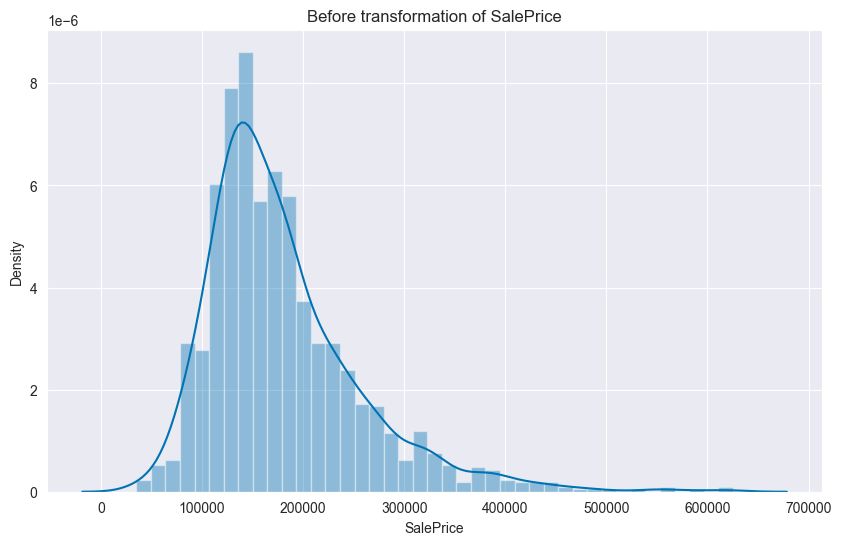

In [146]:
plt.figure(figsize=(10,6))
plt.title("Before transformation of SalePrice")
dist = sns.distplot(train['SalePrice'],norm_hist=False)


分布向右倾斜，即曲线右侧的尾部比左侧的尾部更长，平均值大于众数。这种情况也称为正偏态。

目标变量呈偏斜分布会影响机器学习模型的整体性能，因此缓解的一种方法是对偏斜的目标变量进行对数变换，对我们来说，即对SalePrice进行对数变换以减少分布的偏斜。

d:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


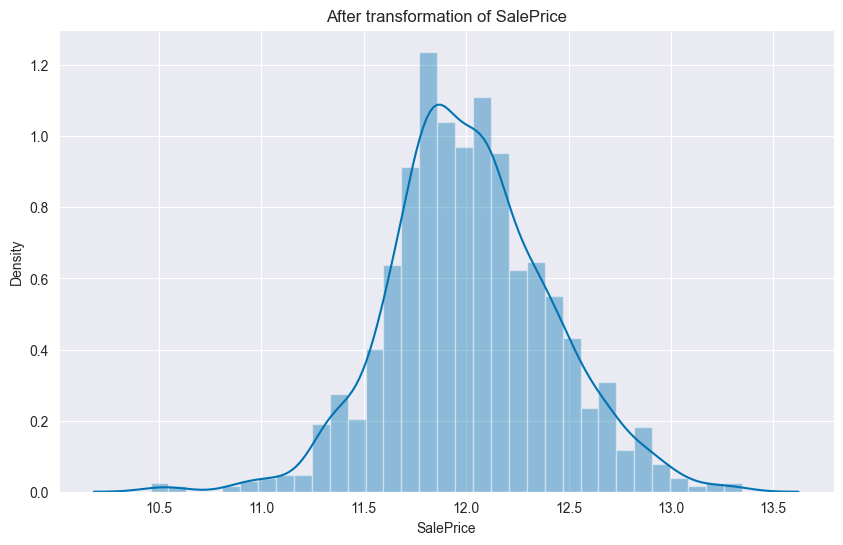

In [147]:
plt.figure(figsize=(10,6))
plt.title("After transformation of SalePrice")
dist = sns.distplot(np.log(train['SalePrice']),norm_hist=False)

In [148]:
y["SalePrice"] = np.log(y['SalePrice'])

## 4. 训练拟合

In [149]:
x = X.loc[train.index]
y = y.loc[train.index]
test = X.loc[test.index]

### 4.1 数据的缩放
RobustScaler 是一种鲁棒的标准化方法，它对数据的缩放不敏感于异常值（outliers）。异常值可能在标准化过程中产生较大的影响，因为标准化通常依赖于数据的均值和标准差。而 RobustScaler 使用中位数和四分位数范围来进行标准化，这使得它对于存在异常值的数据更为稳健。

具体来说，RobustScaler 的标准化公式如下：

标准化后的值 = (原始值 − 中位数) / 四分位数范围
​
 

这种标准化方法对于偏斜分布和存在异常值的数据集特别有用。

In [150]:
from sklearn.preprocessing import RobustScaler

cols = x.select_dtypes(np.number).columns
transformer = RobustScaler().fit(x[cols])
x[cols] = transformer.transform(x[cols])
test[cols] = transformer.transform(test[cols])

### 4.2. 集成算法

In [151]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2020)

In [152]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn import ensemble
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

**GBDT**

In [153]:
# 构建GBDT
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train.values.ravel())

GradientBoostingRegressor()

    Ground Truth    Predict
0      11.827043  11.909066
1      11.385092  11.610876
2      12.154779  12.116270
3      12.106252  12.154378
4      12.230765  12.317254
5      11.824080  11.692774
6      11.608236  11.571286
7      11.385092  11.445487
8      12.193494  12.056773
9      12.736701  12.565335
10     11.755872  11.886900
11     12.175613  12.119327
12     11.648365  11.564225
13     12.132695  12.199760
14     11.849398  11.761501


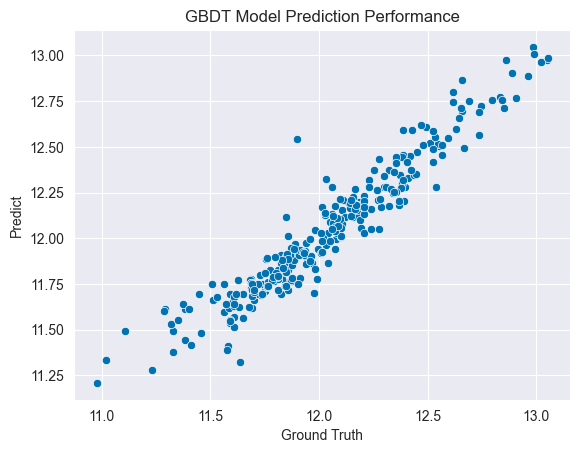

In [154]:
# 对测试集进行预测
y_pred = gbr.predict(X_test)
y_test_values = y_test.values.reshape(-1)
y_pred_values = y_pred.reshape(-1)

# 创建 DataFrame 存储实际值和预测值
compare_df = pd.DataFrame({'Ground Truth': y_test_values, 'Predict': y_pred})
print(compare_df.head(15))

# 使用 Seaborn 绘制散点图比较预测值和实际值
sns.scatterplot(x='Ground Truth', y='Predict', data=compare_df)
plt.xlabel("Ground Truth")
plt.ylabel("Predict")
plt.title("GBDT Model Prediction Performance")
plt.show()


In [155]:
# 计算不同的性能指标
mse = mean_squared_error(y_test_values, y_pred_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_values, y_pred_values)
r2 = r2_score(y_test_values, y_pred_values)
n = y_test_values.shape[0]
p = X_test.shape[1]
Adjusted_R2 = 1-(1-r2)*(n-1)/(n-p-1)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}")
print(f"Adjusted R^2: {Adjusted_R2}")

MSE: 0.01231878439928166
RMSE: 0.11099001936787677
MAE: 0.07953328394813781
R^2: 0.9170670301999976
Adjusted R^2: 0.6410363993731238


**XGBoost**

In [156]:
xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror')

In [157]:
# xgb = XGBRegressor(booster='gbtree', learning_rate=0.3, n_estimators=3000,
#                     max_depth=6, min_child_weight=1, subsample=1,
#                     gamma=0, reg_alpha = 0.001, colsample_bytree=0.7,
#                     objective='reg:squarederror', reg_lambda = 0.001,
#                     scale_pos_weight=1, seed=2020)

xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

    Ground Truth    Predict
0      11.827043  11.800488
1      11.385092  11.688213
2      12.154779  12.163074
3      12.106252  12.093596
4      12.230765  12.365135
5      11.824080  11.713260
6      11.608236  11.618232
7      11.385092  11.357968
8      12.193494  12.081791
9      12.736701  12.523684
10     11.755872  11.864173
11     12.175613  12.200335
12     11.648365  11.759065
13     12.132695  12.245830
14     11.849398  11.853657


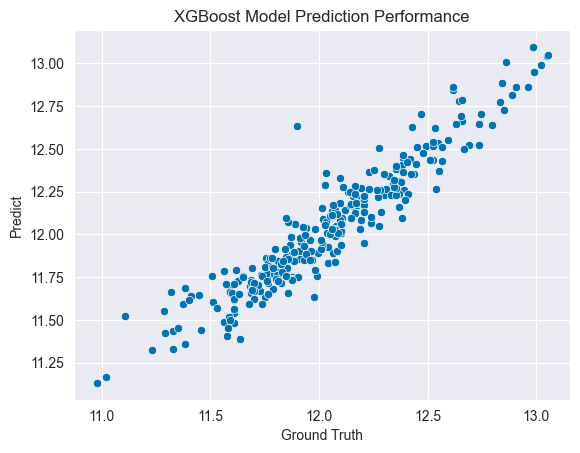

In [158]:
# 对测试集进行预测
y_pred = xgb.predict(X_test)
y_test_values = y_test.values.reshape(-1)
y_pred_values = y_pred.reshape(-1)

# 创建 DataFrame 存储实际值和预测值
compare_df = pd.DataFrame({'Ground Truth': y_test_values, 'Predict': y_pred})
print(compare_df.head(15))

# 使用 Seaborn 绘制散点图比较预测值和实际值
sns.scatterplot(x='Ground Truth', y='Predict', data=compare_df)
plt.xlabel("Ground Truth")
plt.ylabel("Predict")
plt.title("XGBoost Model Prediction Performance")
plt.show()


In [159]:
mse = mean_squared_error(y_test_values, y_pred_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_values, y_pred_values)
r2 = r2_score(y_test_values, y_pred_values)
n = y_test_values.shape[0]
p = X_test.shape[1]
Adjusted_R2 = 1-(1-r2)*(n-1)/(n-p-1)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}")
print(f"Adjusted R^2: {Adjusted_R2}")

MSE: 0.015253395646926172
RMSE: 0.12350463815956943
MAE: 0.09039038392046223
R^2: 0.8973105332854285
Adjusted R^2: 0.5555232037727504


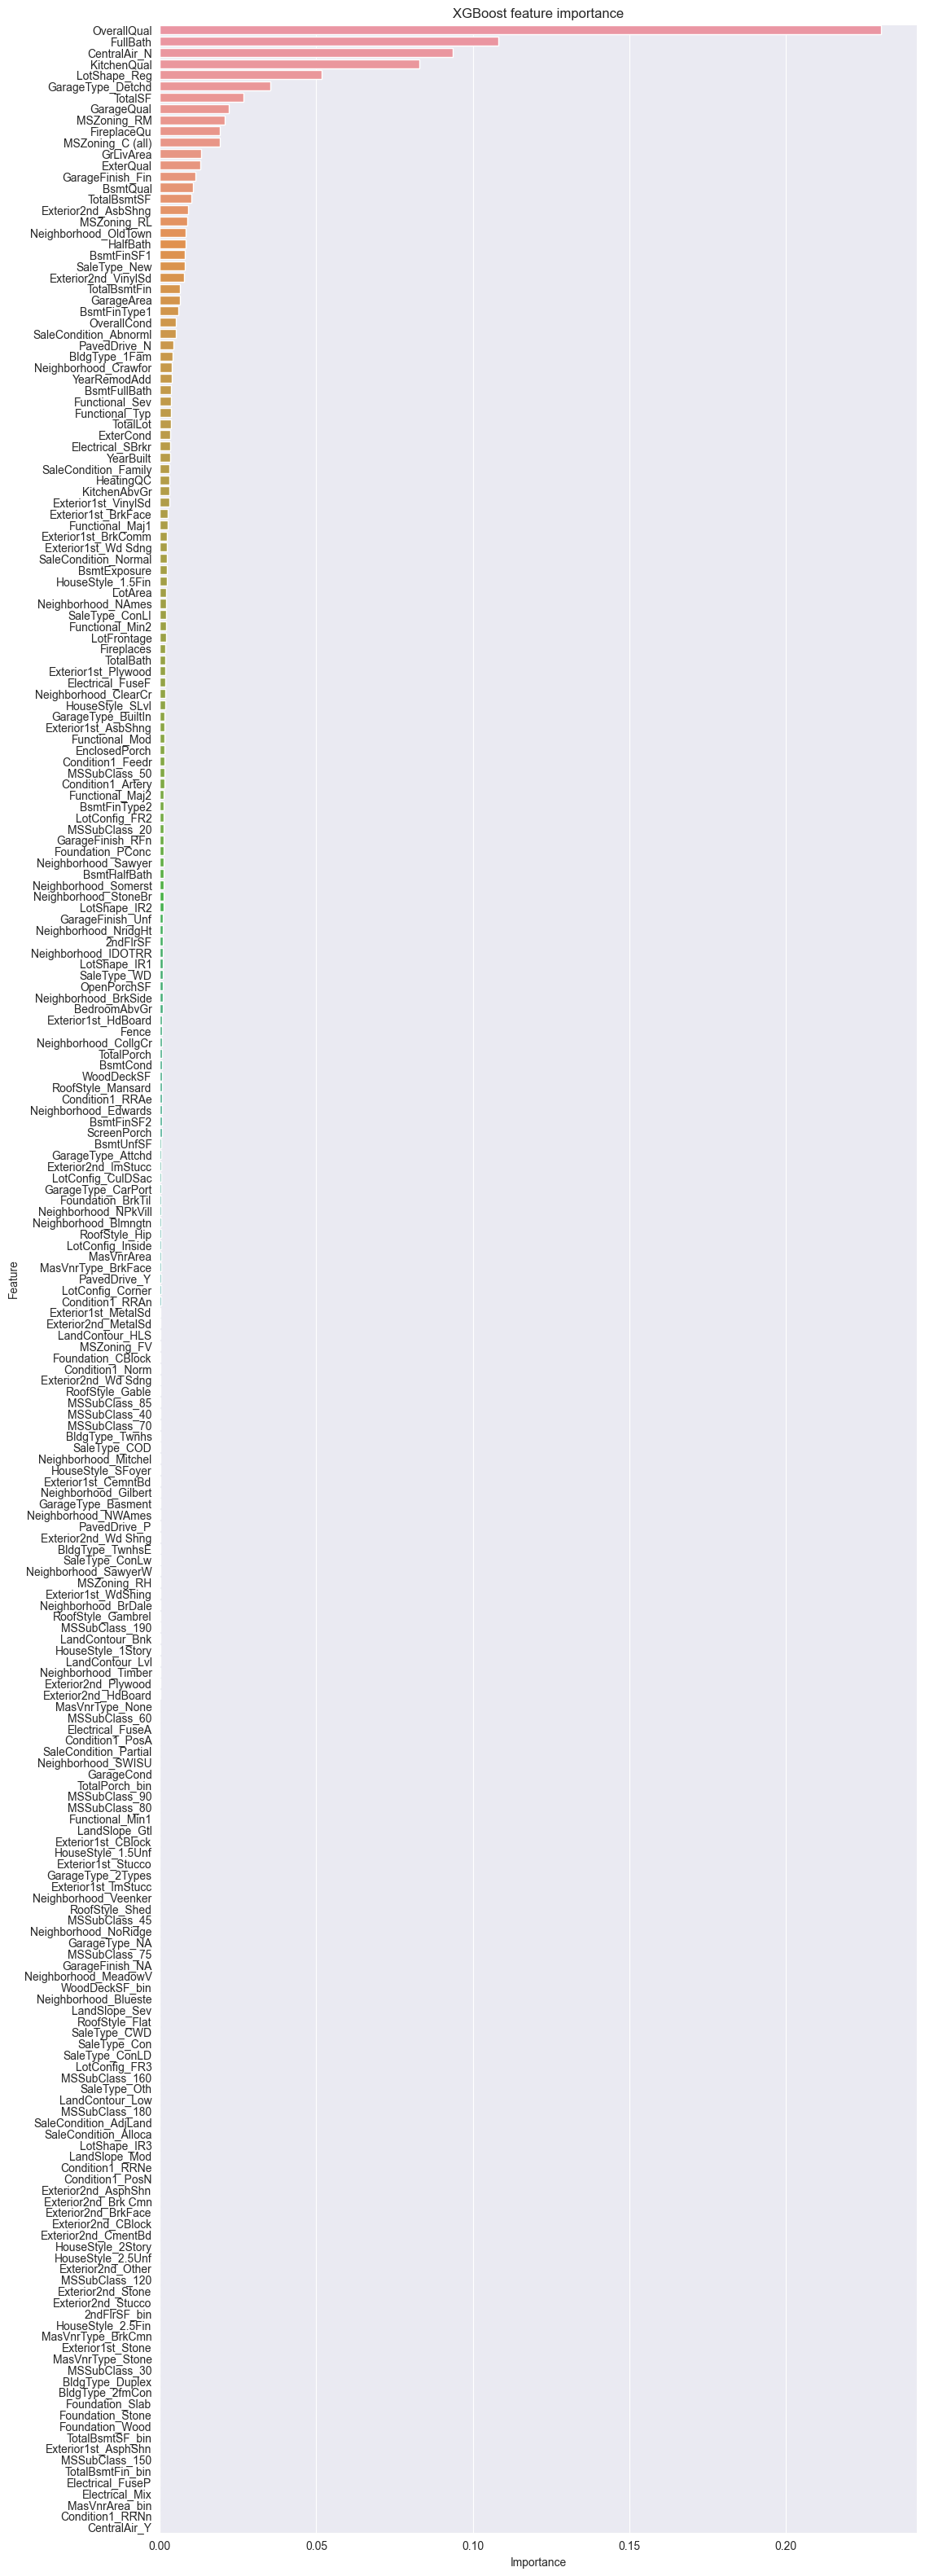

In [160]:
# 获取特征重要性和特征名称
feature_importances = xgb.feature_importances_
feature_names = X_train.columns

# 创建 DataFrame 存储特征重要性
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 使用 Seaborn 绘制特征重要性条形图
plt.figure(figsize=(12,40))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost feature importance")
plt.show()


**Compare**

Training models: 100%|██████████| 50/50 [02:23<00:00,  2.86s/it]


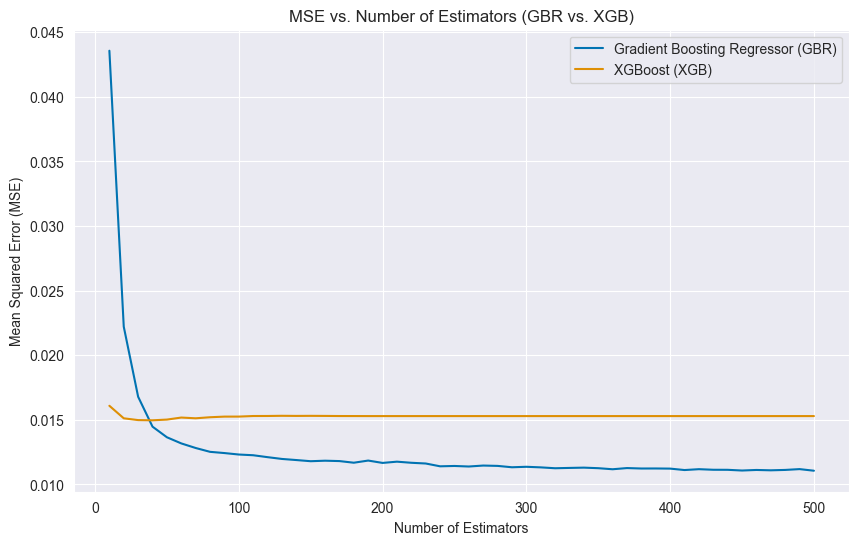

In [166]:
from tqdm import tqdm

# Initialize arrays to store MSE values
mse_gbdt_values = []
mse_xgb_values = []

# Iterate over the specified range of n_estimators with tqdm
for i in tqdm(range(10, 501, 10), desc='Training models'):
    gbr = GradientBoostingRegressor(n_estimators=i)
    xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror', n_estimators=i)
    gbr.fit(X_train, y_train.values.ravel())
    xgb.fit(X_train, y_train.values.ravel())
    y_pred_gbdt = gbr.predict(X_test)
    y_pred_xgb = xgb.predict(X_test)
    
    # Calculate MSE and append to the respective lists
    mse_gbdt = mean_squared_error(y_test, y_pred_gbdt)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    mse_gbdt_values.append(mse_gbdt)
    mse_xgb_values.append(mse_xgb)

# Plot the MSE values using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(10, 501, 10), y=mse_gbdt_values, label='Gradient Boosting Regressor (GBR)')
sns.lineplot(x=range(10, 501, 10), y=mse_xgb_values, label='XGBoost (XGB)')
plt.title('MSE vs. Number of Estimators (GBR vs. XGB)')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()


当然这里只评估了弱分类器个数对模型的影响，模型本身有许多参数可以调整，比如弱分类器的个数、学习率、损失函数等，这些参数的调整对模型的性能影响很大，这里就不一一列举，读者可以通过随机调优，贝叶斯调优等方式完善模型，使其获得更好的性能。